In [1]:
import numpy as np
from collections import Counter
import glob
from copy import copy

from matplotlib import pyplot as plt
import matplotlib
from matplotlib.patches import Patch
# import matplotlib.patheffects
# from matplotlib.legend_handler import HandlerBase
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# import reproject
# from reproject import reproject_interp

from astropy.time import Time
import astropy.table as at
import astropy.coordinates as coords
import astropy.units as u
from astropy.visualization import  hist as ahist, ImageNormalize #, ZScaleInterval, AsymmetricPercentileInterval
from astropy.wcs import WCS
# import astropy.io.fits as afits
# import astropy.wcs as aw

# from astropy.visualization.wcsaxes import WCSAxes, Quadrangle
# import astropy.visualization.wcsaxes.frame as frame

import regions
from regions import PolygonSkyRegion, PolygonPixelRegion #,PixCoord, RectangleSkyRegion, RectanglePixelRegion

from ligo.skymap import plot # we don't use this module directly, but it provides the astro zoom projection
from ligo.skymap.io import fits # sigh, ofc ligo.skymap needs it's own fits reader for HEALPix FITS
# from ligo.skymap import postprocess
# from ligo.skymap.plot import mellinger

%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
### READ DATA

# read pointings - these came from Curtis McCully at LCO

pointings = at.Table.read('gw190814_pointings.csv')

# read field sizes
fieldsize = at.Table.read('treasuremap_instruments.csv')

# read instrument names
instrs = at.Table.read('tm_instrumnt_names.csv')

# get the skymap files

skymap_files = glob.glob('*fits')
dates, times = zip(*[x.split('_')[1].rstrip('fits').split('T') for x in skymap_files])
times = [x.replace('-',':') for x in times]
skymap_mjds = [Time('T'.join((x,y))).mjd for x, y in zip(dates, times)]
skymap_obs = np.zeros(len(skymap_files), dtype='int')
skymaps = at.Table([skymap_files, skymap_mjds, skymap_obs], names=['fn','mjd','obs'])
skymaps.sort('mjd')
skymaps

fn,mjd,obs
str40,float64,int64
bayestar_2019-08-14T21-31-29.fits,58709.89686342593,0
bayestar_2019-08-14T22-58-20.fits,58709.95717592593,0
LALInference.v1_2019-08-15T09-07-14.fits,58710.38002314815,0


<IPython.core.display.Javascript object>


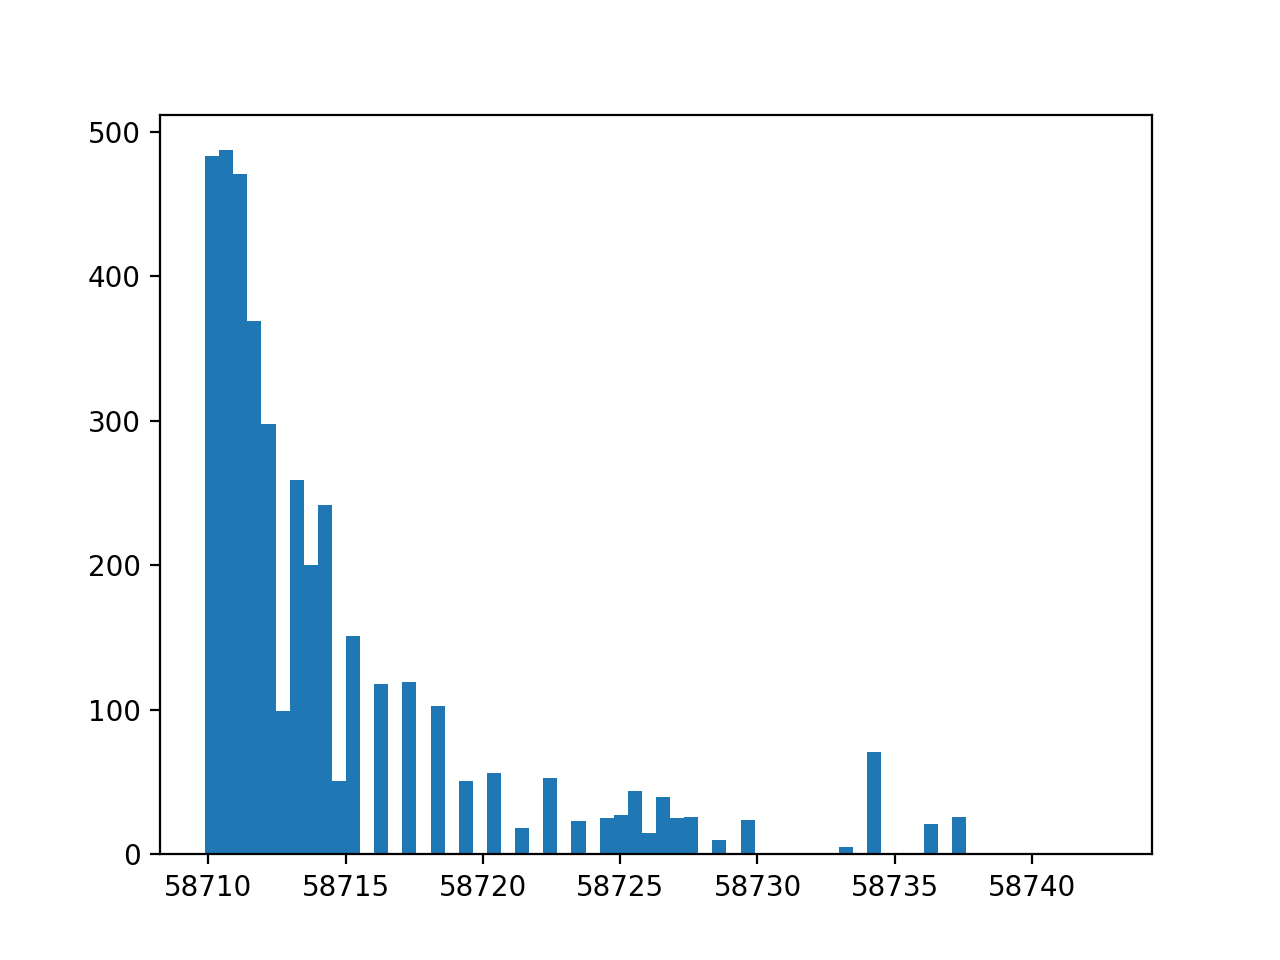

In [3]:
### PROCESS OPTICAL FOLLOWUP POINTINGS

centers = coords.SkyCoord( [x.replace('POINT (','').rstrip(')') for x in pointings['position']],\
                            unit=(u.deg, u.deg), frame='icrs') 
angles = pointings['pos_angle']*u.deg
time = Time(pointings['time'], format='isot', scale='utc').mjd
pointings['position'] = centers
pointings['angles'] = angles
pointings['time'] = time


uniq_instruments = Counter(pointings['instrument'])
# setup some colors
try:
    uniq_instruments.pop(49)
    uniq_instruments.pop(65)
except KeyError as e:
    pass
colors = {x:f'C{i}' for i, x in enumerate(uniq_instruments)}
colors[47] = 'black'


inst_names_vertices = {}
for instrument in uniq_instruments:
    ind_fp = np.where(fieldsize['instrumentid'] == instrument)[0]

    ind_name = instrs['id'] == instrument
    #print(instrs['nickname'][ind_name][0], fieldsize['footprint'][ind_fp][0])
    ra_verts = []
    dec_verts = []
    for ind_fpx in ind_fp:
        thisvertices = fieldsize['footprint'][ind_fpx].replace('POLYGON ((', '').rstrip(')').split(',')
        thisvertices = [x.strip().split() for x in thisvertices]
        thisra_verts, thisdec_verts = zip(*thisvertices)
        thisra_verts = np.array(thisra_verts, dtype='float64')*u.deg
        thisdec_verts = np.array(thisdec_verts, dtype='float64')*u.deg
        ra_verts.append(thisra_verts)
        dec_verts.append(thisdec_verts)
    inst_names_vertices[instrument] = (instrs['nickname'][ind_name][0], ra_verts, dec_verts)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ahist(time, ax=ax, bins='knuth')
mintime = time.min()
maxtime = mintime + 7.01 # no point going later because any observations that were this late wasn't discovering 
                         # so much as conducting a post-mortem

In [4]:
### MAKE PLOT

def make_bkg_plot(fits_file):
    
    # read skymap
    skymap, metadata = fits.read_sky_map(fits_file, nest=None)
    fig = plt.figure(figsize=(7,7.5))
    
    # create axis
    ax = plt.axes(projection='astro zoom', center="1h10m -28d", radius="9 deg")
    
    # plot map
    ax.imshow_hpx(fits_file, cmap='cylon')

    # quadrangle test
    #r = Quadrangle((15.0, -28.9)*u.deg, 10*u.deg, 0.15*u.deg,
    #               edgecolor='green', facecolor='none',
    #               transform=ax.get_transform('fk5'))
    #ax.add_patch(r)
    # OK so this behaves like it should with curved grid lines

    # backdrop - Mellinger if wanted - don't think it adds much at this scale
    #backdrop = mellinger()
    #backdrop_wcs = WCS(backdrop.header).dropaxis(-1)
    #frame = aw.utils.wcs_to_celestial_frame(backdrop_wcs)
    #interval = AsymmetricPercentileInterval(45, 99)
    #frame = backdrop_wcs.celestial?
    #norm = ImageNormalize(backdrop.data, interval)
    #backdrop_reprojected = np.asarray([
    #    reproject_interp((layer, backdrop_wcs), ax.header)[0]
    #    for layer in norm(backdrop.data)])
    #backdrop_reprojected = np.rollaxis(backdrop_reprojected, 0, 3)
    #ax.imshow(backdrop_reprojected, alpha=0.25)


    # decorations
    ax.compass(0.95, 0.05, 0.1)
    ax.grid()
    ax.set_xlabel('RA (hh:mm)')
    ax.set_ylabel('$\delta$ ($\degree$)')

    legend_elements = []

    for inst in uniq_instruments:
        inst_name, _, _ = inst_names_vertices[inst]
        color = colors[inst]
        patch = Patch(facecolor='None', edgecolor=color, alpha=1, label=inst_name)
        legend_elements.append(patch)

    ax.legend(handles=legend_elements, bbox_to_anchor=(0., 1.01, 1., .13), loc='lower left',\
                ncol=6, mode="expand", borderaxespad=0., fontsize='x-small')
    plt.figtext(0.5, 0.97, "GW190814 Followup", horizontalalignment='center',va='center_baseline',
                fontsize='large',weight='bold' );
    return fig, ax

<IPython.core.display.Javascript object>


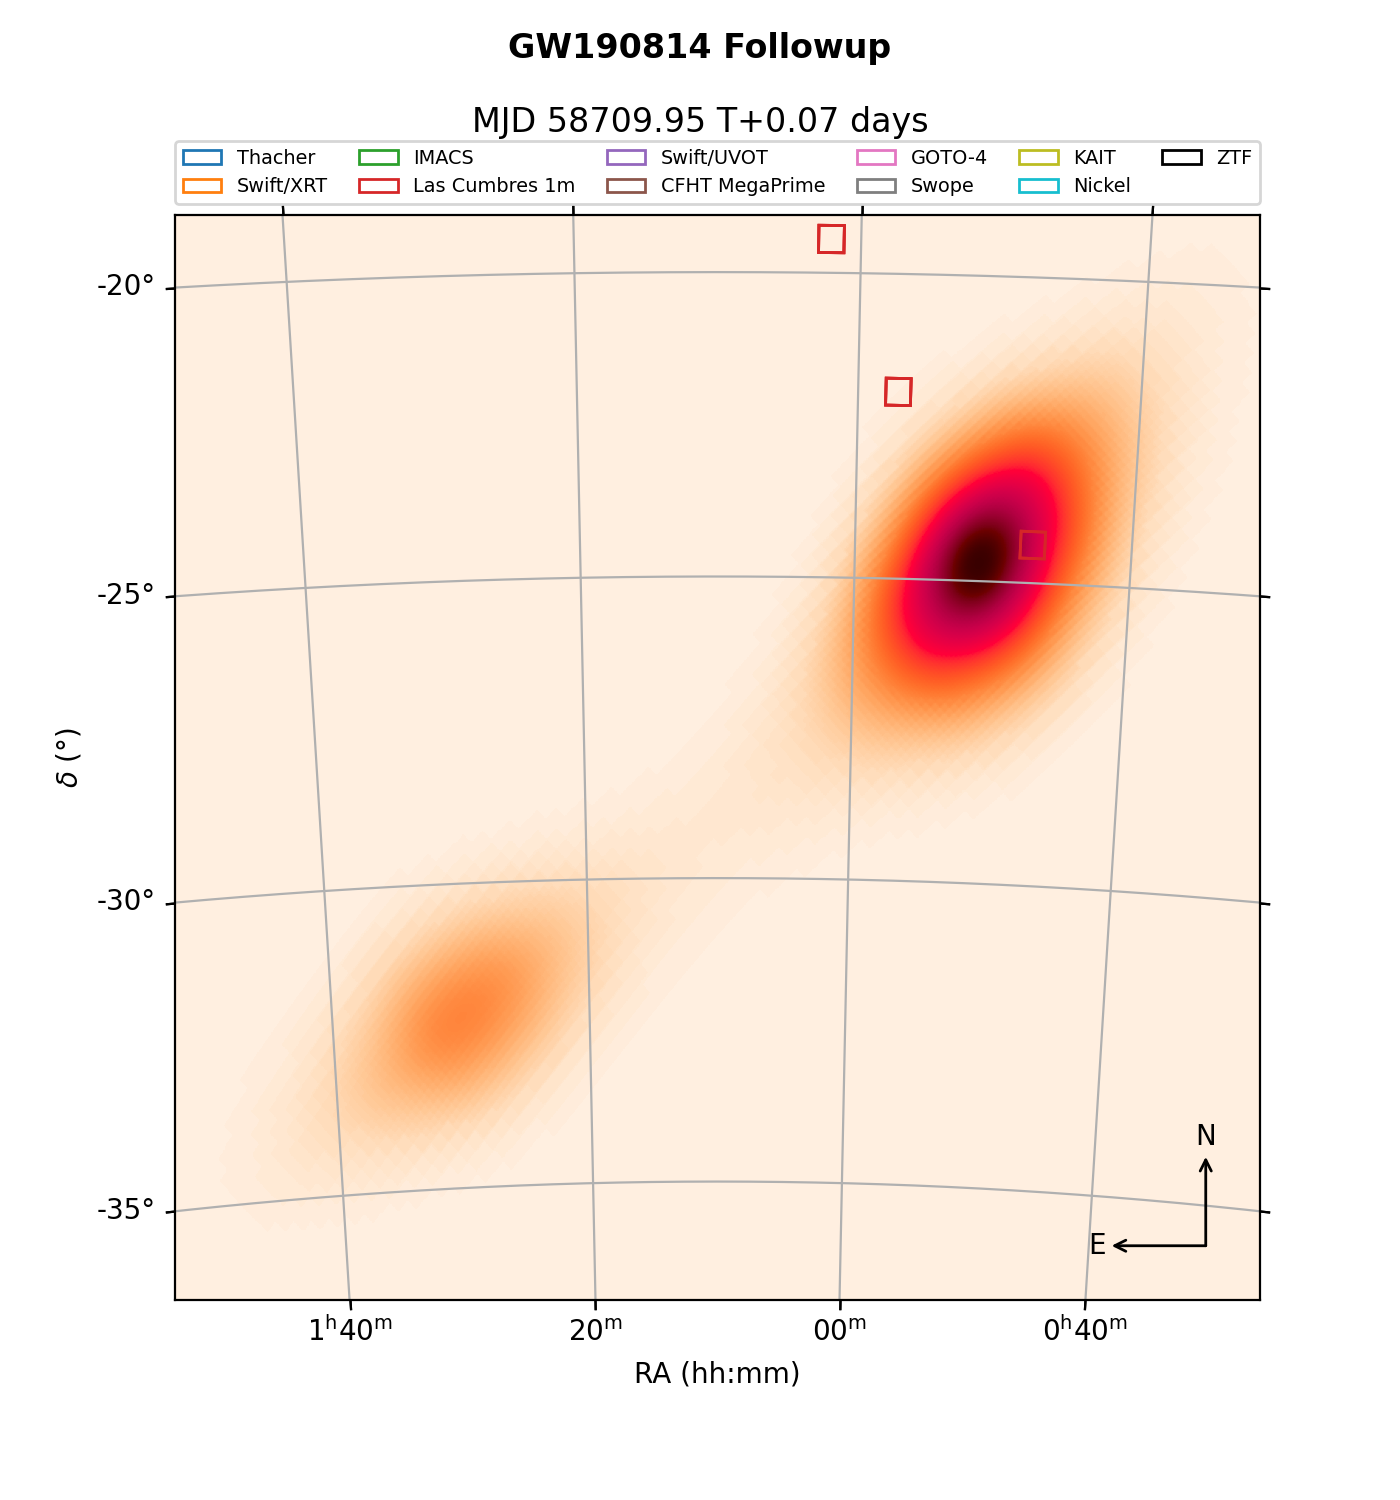

<IPython.core.display.Javascript object>


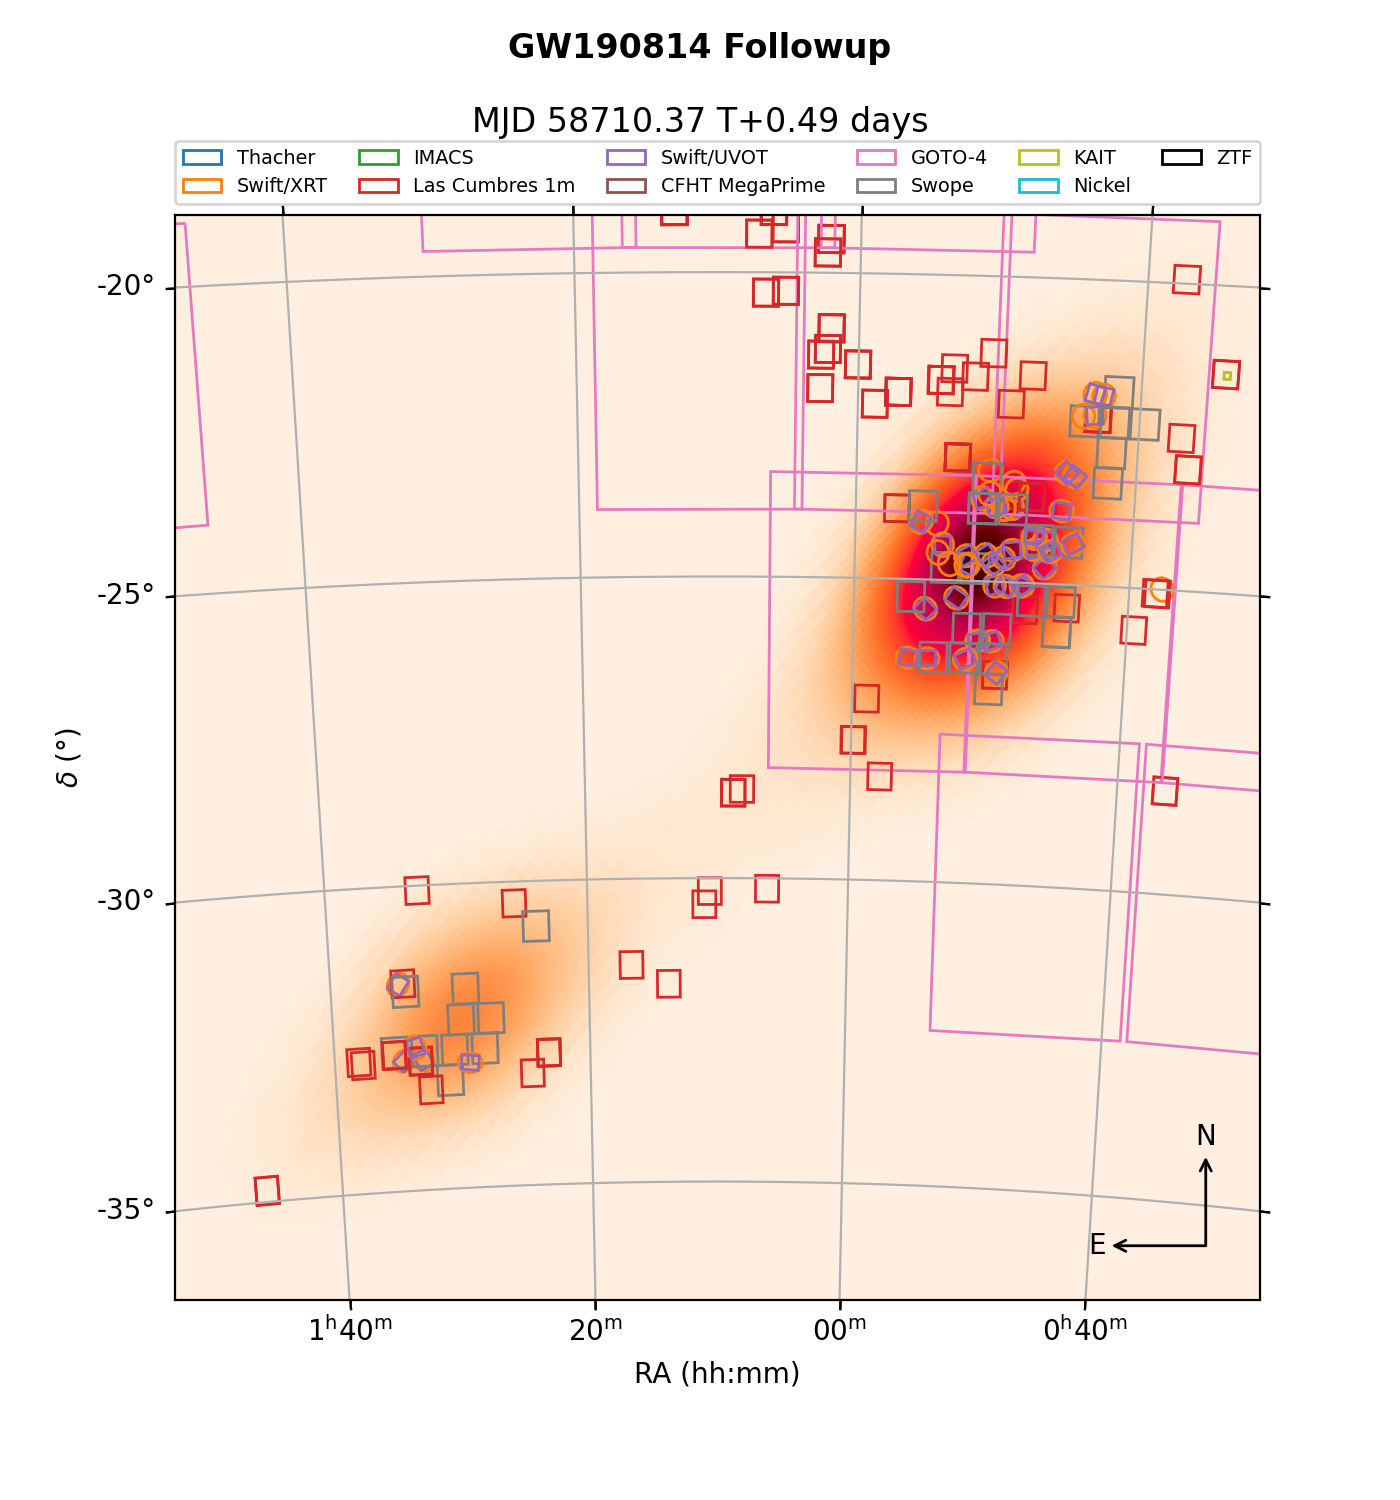

58709.960371313886
                   fn                           mjd        obs
---------------------------------------- ----------------- ---
       bayestar_2019-08-14T21-31-29.fits 58709.89686342593   1
       bayestar_2019-08-14T22-58-20.fits 58709.95717592593   1
LALInference.v1_2019-08-15T09-07-14.fits 58710.38002314815   0


<IPython.core.display.Javascript object>


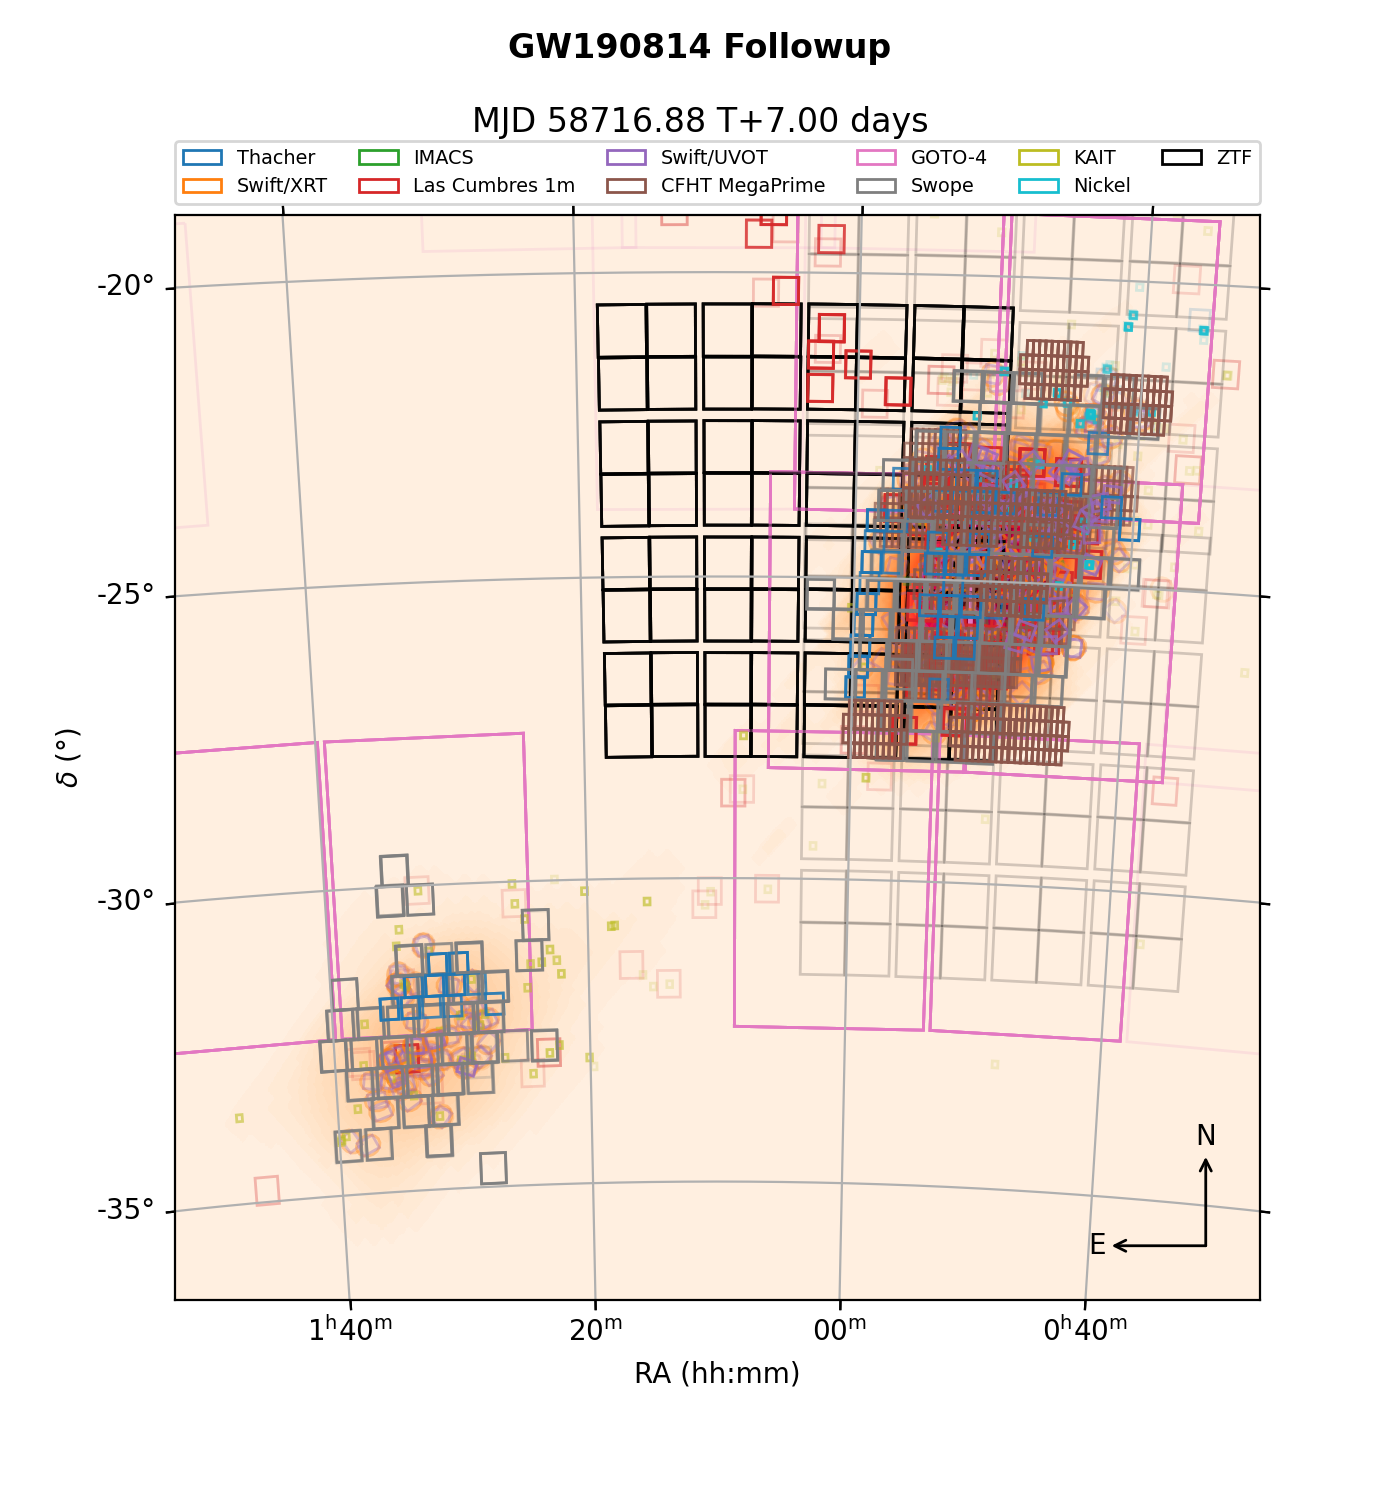

58710.38143916705
                   fn                           mjd        obs
---------------------------------------- ----------------- ---
       bayestar_2019-08-14T21-31-29.fits 58709.89686342593   1
       bayestar_2019-08-14T22-58-20.fits 58709.95717592593   1
LALInference.v1_2019-08-15T09-07-14.fits 58710.38002314815   1


In [5]:
nframes = 30 * 30
time_grid = np.linspace(mintime, maxtime, nframes, endpoint=True)



trigger_time = Time("2019-08-14T21:10:38.996").mjd
patches = []
all_regions = []
used_instr = []

fig, ax = make_bkg_plot(skymaps['fn'][0])
skymaps['obs'][0] = 1

for i, t in enumerate(time_grid[:-1]):
    
    # update the background skymap as time goes on, but each map is used only once
    for k, skymap in enumerate(skymaps):
        if (t > skymap['mjd']) and (skymap['obs'] == 0):
            fig, ax = make_bkg_plot(skymap['fn'])
            skymaps['obs'][k] = 1
            
            print(t)
            print(skymaps)
            
            # we updated the figure, so we need to redraw old patches
            # preserving their position, color and transparency
            for l, patch in enumerate(patches):
                edgecolor = patch.get_edgecolor()
                alpha = patch.get_alpha()
                region_pix = all_regions[l]
                new_patch = region_pix.plot(ax=ax, facecolor='none', edgecolor=edgecolor,\
                        lw=1, alpha=alpha)
                # replace the old patch
                patches[l] = new_patch
                
       
    # get the WCS from the axis via shenanigans 
    wcs = ax.get_transform('world')._a.wcs
    
    # get the observations that are within this time-step
    ind_time = np.where((time >= t) & (time < time_grid[i+1]))
    
    # label for the figure - do this first, so if something borks, you can see when it happened
    label = f'\n\nMJD {t:0.2f} T{t-trigger_time:+0.2f} days'
    fig.suptitle(label)
    
    # check that we have some observations in this time-step 
    if len(ind_time) > 0:
        these_pointings = pointings[ind_time]

        # assuming we have observations
        for point in these_pointings: 
            # skip Swift since it covers everything and ASKAP since it's not remotely optical
            if point['instrument'] in (49, 65,):
                continue    
            
            # get the instrument vertices
            _, raverts, decverts = inst_names_vertices[point['instrument']]

            # get the vertices of each of the instrument's CCDs
            for j, thisraverts in enumerate(raverts):
                thisdecverts = decverts[j]
                
                # figure out vertex coordinates 
                racoords = point['position'].ra + thisraverts
                deccoords = point['position'].dec + thisdecverts
        
                # convert vertex coordinates to SkyCoord objects so we can enter astropy land
                vertices = coords.SkyCoord(racoords, deccoords, unit='deg', frame='icrs')
            
                # build a polygon in the WCS frame
                region_sky = PolygonSkyRegion(vertices=vertices)
            
                # figure out the center position in pixels
                center_pix = regions.PixCoord(*wcs.world_to_pixel(point['position']))
            
                # get the rotation angle
                angle = point['pos_angle']
            
                # get the polygon in pixel coordinates
                region_pix = region_sky.to_pixel(wcs=wcs)
            
                # rotate the polygon
                region_pix = region_pix.rotate(center_pix, angle)
            
                # plot polygon as a matplotlib match
                patch = region_pix.plot(ax=ax, facecolor='none', edgecolor=colors[point['instrument']]\
                                        , lw=1, alpha=1)
            
                # keep a track of all patches and regions so we can update figure
                # when we update skymaps and turn down the alpha
                patches.append(patch)
                all_regions.append(region_pix)
                
            # end loop over CCDs
        # end loop over pointings
    # endif there are observations - we should save a frame even if nothing has changed
    # this could happen near the end of the week of observing
    fig.savefig(f'outfiles/Frame{i:03d}.png')
        
    # incrementally decrease the alpha of each patch each frame -i.e. fade out old observations
    for patch in patches:
        patch.set_alpha(patch.get_alpha() - 0.001)
